# Line-of-sight displacements and the Okada model
A notebook to use the Okada elastic dislocation model to calculate the displacement field for an earthquake, and to resolve it into satellite line-of-sight

## Setup

If you don't have them already, first we should install some things we need! In this case, <a href="https://github.com/tbenthompson/okada_wrapper">Ben Thompson's Okada wrapper for Python</a>.

In [1]:
pip install okada_wrapper

Note: you may need to restart the kernel to use updated packages.


Let's start by importing some dependencies:

In [1]:
from okada_wrapper import dc3d0wrapper, dc3dwrapper
from numpy import linspace, zeros, log
from math import sin, cos, tan, radians
from matplotlib.pyplot import contourf, contour,\
    xlabel, ylabel, title, colorbar, show, savefig
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import matplotlib.pyplot as plt
import time

And let's set some parameters! First the material properties (Lame elastic parameters) ...

In [10]:
lmda = 30e9  # 30 GPa is a standard value for continental crust
mu = 30e9    # 30 GPa is also a standard value for continental crust
alpha = (lmda + mu) / (lmda + 2 * mu) # elastic constant used by Okada

And now let's define some fault parameters:

In [4]:
strike=1
dip=85
rake=-1
slip=2
as_length=15000  # along-strike length
dd_width=10000   # down-dip width
cd_depth=6000   # centroid depth
xs=0  # x cooordinate of center of up-dip projection of the fault
ys=0  # y coordinate of same

## The Okada elastic dislocation model and geometry

This notebook makes use of the derivation of the expected deformation field for slip on a rectangular dislocation (a fault) in an isotropic elastic half space, that was <a href="https://www.bosai.go.jp/information/pdf/copy_of_Okada_1985_BSSA.pdf">originally published by Yoshimitsu Okada in 1985</a>. This model has become synonymous with its author, so much so that we often refer to it simply as 'Okada'. Although is is a huge simplification of nature (Earth surface is assumed to be flat, the strength of the crust is assumed to be uniform, and any faults are assumed to be rectuangular and planar), the Okada model is very commonly used because it is analytical -- the solution is exact and it can be computed very fast.

The first step with using the Okada model is to convert our fault parameters into the form that the model is expecting. The model geometry, taken here from the <a href="https://www.bosai.go.jp/information/dc3d_e.html">web page on the model</a> hosted at the National Research Institute for Earth Science and Disaster Resilience in Japan, defines a coordinate system with its origin at a reference point on the fault.

<img src="dc3d.png" align=center>

[figure <a href="https://www.bosai.go.jp/information/img/copy_of_dc3d1-1.png">source</a>]


For convenience, we will assume the reference point is the center, or "centroid" of the fault. In this case, the along-strike dimensions parameters AL1 and AL2 are equal in magnitude (half of the along-strike length), as are the down-dip dimensions AW1 and AW2 (half of the down-dip width). We can calculate the centroid location with a little trig:

In [5]:
# calculate the centroid coordinates
rc=cd_depth/tan(radians(dip))  # radial surface distance from (xs,ys) to centroid
rcx=rc*sin(radians(strike+90)) # coordinate shift in x from xs to centroid 
rcy=rc*cos(radians(strike+90)) # coordinate shift in y from ys to centroid
xc=xs+rcx  # x coordinate of centroid
yc=ys+rcy  # y coordinate of centroid
print('fault centroid is at (' + repr(xc) + ', ' + repr(yc) + ', ' + repr(cd_depth) +')')

fault centroid is at (524.8520314722487, -9.161326287054981, 6000)


We also need to convert from slip and rake into strike-slip and dip-slip components:

In [6]:
# convert slip and rake to strike-slip and dip-slip
ss=slip*cos(radians(rake))
ds=slip*sin(radians(rake))
print('strike-slip: ' + repr(ss) + ' m, dip-slip: ' + repr(ds) +' m')

strike-slip: 1.9996953903127825 m, dip-slip: -0.03490481287456702 m


Additionally, the subroutine that computes the Okada model assumes that the fault strike is along the x-axis. To account for this assumption, we need to transform the observation point locations from their map coordinates into 'Okada coordinates'. This turns out to require a counter-clockwise rotation of (strike-90) degrees, which we can accomplish using a rotation matrix.

In [8]:
# make a rotation matrix to account for strike
R=np.array([[cos(radians(strike-90)), -sin(radians(strike-90))], 
            [sin(radians(strike-90)), cos(radians(strike-90))]])

## Running the Okada model

We are ready now to run the Okada model. This involves setting up a grid of coordinates, applying the rotation to those coordinates, computing the displacements, and projecting those displacements into the east and north directions (as the Okada routine assumes that the strike is 90 degrees, and therefore the 'X' displacements it outputs are in the strike-parallel direction). Then we plot the output...  

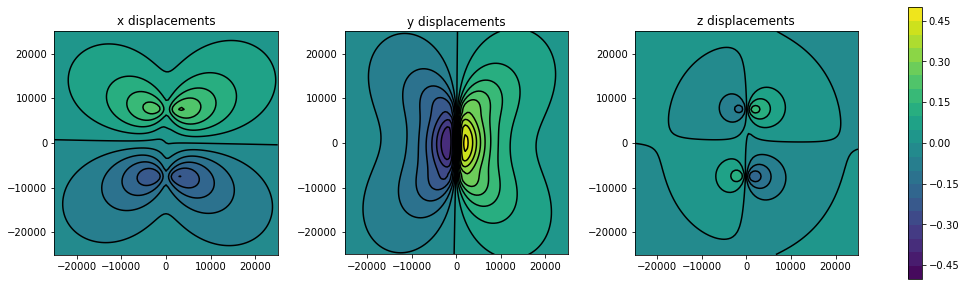

In [11]:
# set up a grid for computation
n = (101, 101)
x = linspace(-25000, 25000, n[0])  # these are the plot bounds
y = linspace(-25000, 25000, n[1])

UX = zeros((n[0], n[1]))  # and these three arrays contain the output
UY = zeros((n[0], n[1]))
UZ = zeros((n[0], n[1]))

    
# loop through the points on your grid
for i in range(n[0]):
    for j in range(n[1]):
            
        # shift and rotate the coordinates into Okada geometry
        P=np.array([[x[i]-xc],[y[j]-yc]]); # observation point wrt centroid in map coordinates
        Q=R.dot(P)                         # observation point rotated into Okada geometry
            
        # run the Okada dc3d function on the rotated coordinates   
        success, u, grad_u = dc3dwrapper(alpha,
                                            [Q[0], Q[1], 0],
                                            cd_depth, dip,
                                            [-as_length/2, as_length/2], 
                                            [-dd_width/2, dd_width/2],
                                            [ss, ds, 0.0])
        assert(success == 0)
        
        # here u[0] is strike-parallel displacement and u[1] is strike-normal displacement
        UX[i, j] = u[0]*sin(radians(strike))-u[1]*cos(radians(strike))   # x displacement
        UY[i, j] = u[0]*cos(radians(strike))-u[1]*sin(radians(strike))   # y displacement
        UZ[i, j] = u[2]   # z displacement        

# and plot the output

fig, (ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(18,5))  # set up three subplots (size in x and y)
fig.subplots_adjust(wspace=0.3)                            # space them out a little

axlist = [ax1,ax2,ax3]   # handles for your subplots

levels = linspace(-0.5, 0.5, 21)   # the bounds of your color scale - adjust if necessary

cntrf = ax1.contourf(x, y, UX.T, levels = levels)
first = ax1.contour(x, y, UX.T, colors = 'k', levels = levels, linestyles = 'solid')
ax1.axis('image')
ax1.title.set_text('x displacements')

cntrf = ax2.contourf(x, y, UY.T, levels = levels)
second = ax2.contour(x, y, UY.T, colors = 'k', levels = levels, linestyles = 'solid')
ax2.axis('image')
ax2.title.set_text('y displacements')

cntrf = ax3.contourf(x, y, UZ.T, levels = levels)
third = ax3.contour(x, y, UZ.T, colors = 'k', levels = levels, linestyles = 'solid')
ax3.axis('image')
ax3.title.set_text('z displacements')

fig.colorbar(cntrf, ax=axlist)

plt.show()
            
            

## Resolving displacements into satellite line-of-sight

Next, we can consider satellite line-of-sight. The deformation that InSAR measures is a projection of the 3D displacement field we just calculated into the vector direction in which the SAR antenna is pointing, which we call the line-of-sight vector, or pointing vector. In ISCE, a by-product of the processing is information on the acquisition geometry, the angles required to calculate the pointing vector.

The file 'los.rdr.geo' produced by both topsApp and stripmapApp contains two layers, representing two angles estimated at each pixel: 1) the incidence, $\theta$,  i.e. the angle between the horizontal at the ground target, and the ray path from the satellite to that target; and 2) the pointing direction, $\phi$, from the ground target to the satellite, in degrees counter-clockwise from north. This is not constant for Sentinel-1 TOPS data, given the sweeping of the beam backwards and forwards in the along-track direction. (Note that in the literature, you will also find calculations of the pointing vector based on the satellite heading direction, which is approximately 90 degrees different from the pointing direction. Do not get the two confused!)

The x, y and z components of the unit pointing vector, $\hat{p}$, can be calculated from these two angles (if you would like to practice your geometry and trigonometry, have a go at trying to derive the vector components yourself):

$$\hat{p} = [\hat{p}_x,\; \hat{p}_y,\; \hat{p}_z] = [\sin\phi\sin\theta, \; {-\cos\phi\sin\theta}, \; {-\cos{\theta}}]$$

For simplicity here, we will assume that the angles are fixed for the whole area. (For real data, of course, you can use the actual values for each pixel.)

Also, note that the sign convention that we are using is <i>range change</i>. Positive values of $u_{LOS}$ indicate motion of the ground away from the satellite.

In [12]:
theta = 39   # appropriate for Sentinel-1 subswath 2
#phi = -100   # angle from north, pointing from target to satellite, positive counter-clockwise, descending
phi = -260   # angle from north, pointing from target to satellite, positive counter-clockwise, ascending

p_vec = [sin(radians(phi))*sin(radians(theta)), -cos(radians(phi))*sin(radians(theta)), -cos(radians(theta))];

print('Pointing vector components: px = ' + repr(p_vec[0]) + ', py = ' + repr(p_vec[1]) + ', pz = ' + repr(p_vec[2]))

Pointing vector components: px = 0.6197596002345545, py = 0.10928033907444423, pz = -0.7771459614569709


What do you think happens to the relative sizes of the east and vertical components of the east and north components of the pointing vector as you move between different subswaths of Sentinel-1? 

(For reference, appropriate values of incidence ($\theta$) for Sentinel-1: subswath 1 $-$ 31$^\circ$-37$^\circ$, subswath 2 $-$ 37$^\circ$-42$^\circ$, subswath 3 $-$ 42$^\circ$-46$^\circ$.)

Next, we can see how each component contributes to line-of-sight displacement in an interferogram by scaling each displacement component by its corresponding unit pointing vector component. The (synthetic) interferogram we obtain is the sum of these scaled components; in other words, the interferogram, $u_{LOS}$, is the dot product between the 3-component displacement vector for each pixel, $u$, and its unit pointing vector, $\hat{p}$, i.e. 

$$u_{LOS}=\hat{p} \cdot u$$


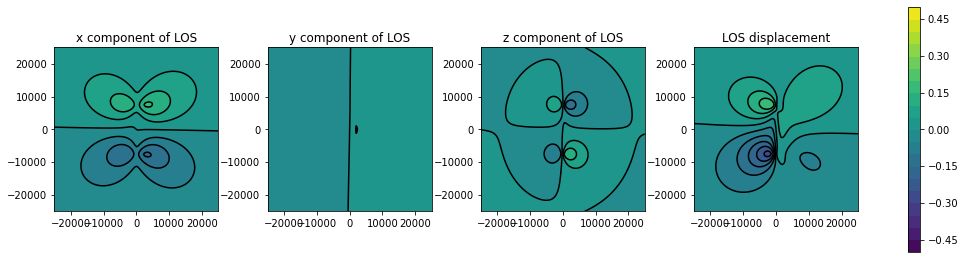

In [13]:
# let's scale the three displacement components
ULOS_X = np.multiply(UX,p_vec[0]) 
ULOS_Y = np.multiply(UY,p_vec[1]) 
ULOS_Z = np.multiply(UZ,p_vec[2]) 

ULOS = ULOS_X + ULOS_Y + ULOS_Z

# and plot the output

fig, (ax1,ax2,ax3,ax4) = plt.subplots(ncols=4,figsize=(18,4.5))  # set up three subplots (size in x and y)
fig.subplots_adjust(wspace=0.3)                            # space them out a little

axlist = [ax1,ax2,ax3,ax4]   # handles for your subplots

levels = linspace(-0.5, 0.5, 21)   # the bounds of your color scale - adjust if necessary

cntrf = ax1.contourf(x, y, ULOS_X.T, levels = levels)
first = ax1.contour(x, y, ULOS_X.T, colors = 'k', levels = levels, linestyles = 'solid')
ax1.axis('image')
ax1.title.set_text('x component of LOS')

cntrf = ax2.contourf(x, y, ULOS_Y.T, levels = levels)
second = ax2.contour(x, y, ULOS_Y.T, colors = 'k', levels = levels, linestyles = 'solid')
ax2.axis('image')
ax2.title.set_text('y component of LOS')

cntrf = ax3.contourf(x, y, ULOS_Z.T, levels = levels)
third = ax3.contour(x, y, ULOS_Z.T, colors = 'k', levels = levels, linestyles = 'solid')
ax3.axis('image')
ax3.title.set_text('z component of LOS')

cntrf = ax4.contourf(x, y, ULOS.T, levels = levels)
third = ax4.contour(x, y, ULOS.T, colors = 'k', levels = levels, linestyles = 'solid')
ax4.axis('image')
ax4.title.set_text('LOS displacement')

fig.colorbar(cntrf, ax=axlist)

plt.show()


What you will typically see, regardless of the source model, is that for satellite InSAR the north component of deformation contributes very little to the total line-of-sight displacement. Also, depending on the input source model, the x and z components of displacements sometimes superpose in some areas and cancel in others, giving rise to a pattern that can look quite different from either. 